<p style="text-align: center;">SEAS 6414 - Python Applications in Data Analytics</p>
<p style="text-align: center;">Homework 7</p>
<p style="text-align: center;">Due Date: March 2, 2024 (10:00am EST)</p>

Instructions: To complete the following task using Python, please download an
Integrated Development Environment (IDE) of your choice. Ensure that your solution
includes both the written code (input) and its corresponding output. Once completed,
upload your solution in PDF format or any other format you prefer. The questions
are worth 50 points each.

# Question 1: Segmentation, Assignment Generation, and Churn Prediction Using Merchant Transaction Activity
## Dataset and Objective
- Dataset: homework7 file1.csv
- Data Description: This dataset contains records of merchant transactions, each
with a unique merchant identifier, time of transaction, and amount in cents.
- Objective: Analyze merchant transaction data to understand business growth
and health. Preprocess the dataset for future transactions and generate specific
features for each merchant.

All of the imports

In [23]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # "Support vector classifier"

## Task 1: Feature Generation
### Generate the following features for each unique merchant:
- trans amount min: Minimum transaction amount for each merchant.
- trans amount max: Maximum transaction amount for each merchant.
- trans amount avg: Average transaction amount for each merchant.
- trans amount volume: Total transaction amount for each merchant.
- trans frequency: Total count of transactions for each merchant.
- trans recency: Recency of the last transaction (in days from 1/1/2035).
- avg time btwn trans: Average time between transactions (in hours).
- avg trans growth rate: Average growth rate in transaction amounts.

In [4]:

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

HW7F1 = pd.read_csv('./homework7_file1.csv')

In [5]:
HW7F1.shape


(100000, 3)

In [6]:
HW7F1.head()

,merchant,time,amount_usd_in_cents
0,d087d4c321,2034-12-11 22:16:41,5059
1,fe1cb2e840,2034-08-13 21:11:59,12743
2,878047f4b9,2033-06-05 21:15:00,7601
3,3932608d23,2034-04-28 19:55:01,5790
4,84a09b4188,2034-07-26 04:37:05,6153


In [7]:
HW7F1['merchant'].nunique()

7902

In [8]:
#transform to datetime format
HW7F1['time'] = HW7F1['time'].apply(pd.to_datetime)

In [9]:
#sort time, group by merchant, and aggregate into a list
HW7F1ST = HW7F1.sort_values(by='time')
data1_agg = HW7F1ST.groupby('merchant').agg(list).reset_index()

In [10]:
data1_agg.head()

,merchant,time,amount_usd_in_cents
0,00057d4302,"[2033-05-30 02:54:34, 2033-05-30 04:20:31]","[1156, 1279]"
1,000ed1585f,"[2033-05-08 15:51:43, 2033-05-19 13:15:51, 203...","[32004, 35784, 21932, 22481]"
2,000f8c3297,"[2033-12-20 17:57:20, 2034-01-26 15:10:54, 203...","[7374, 14489, 15047, 4623, 3826, 3643, 4155, 7..."
3,0020aefbd9,[2034-05-30 21:55:06],[3589]
4,0026f256ac,[2033-09-15 01:17:32],[34880]


In [11]:
data1_agg.shape

(7902, 3)

In [12]:
#function that calculates the average time between transactions for each merchant
def avg_time_btwn_trans(y):
    if len(y) == 1:
        return 0 
    else:
        td = np.mean([z1 - z0  for z0, z1 in zip(y,y[1:])])
        td_hrs = (td.days)*24 + (td.seconds)/(60*60)
        avg_time_btwn_trans = np.round(td_hrs, 2)
        return avg_time_btwn_trans

In [13]:
#function that calculates the average transaction growth rate for each merchant
def avg_trans_growth_rate(y):
    if len(y) == 1:
        return 0 
    else:
        grw = np.mean([(z1 - z0)/z0  for z0, z1 in zip(y,y[1:])])
        avg_trans_growth_rate = np.round(grw, 2)
        return avg_trans_growth_rate

In [14]:
HW7F1['time'].max()

Timestamp('2034-12-31 07:55:58')

In [15]:
def get_aggregated(x):
    x['trans_amount_min'] = x['amount_usd_in_cents'].apply(lambda y: np.round(np.min(y), 2))
    x['trans_amount_max'] = x['amount_usd_in_cents'].apply(lambda y: np.round(np.max(y), 2))
    x['trans_amount_avg'] = x['amount_usd_in_cents'].apply(lambda y: np.round(np.mean(y), 2))
    x['trans_amount_volume'] = x['amount_usd_in_cents'].apply(lambda y: np.round(np.sum(y),2))
    x['trans_frequency'] = x['amount_usd_in_cents'].apply(lambda y: len(y))
    x['trans_recency'] = x['time'].apply(lambda t: (np.datetime64('2035-01-01') - np.max(t)).days + 1)
    x['avg_time_btwn_trans'] = x['time'].apply(lambda t: avg_time_btwn_trans(t))
    x['avg_trans_growth_rate'] = x['amount_usd_in_cents'].apply(lambda y: avg_trans_growth_rate(y))
    return x

In [16]:
new_dataset = get_aggregated(data1_agg).drop(columns=['time','amount_usd_in_cents'])

In [17]:
new_dataset.head()

,merchant,trans_amount_min,trans_amount_max,trans_amount_avg,trans_amount_volume,trans_frequency,trans_recency,avg_time_btwn_trans,avg_trans_growth_rate
0,00057d4302,1156,1279,"1,217.50",2435,2,581,1.43,0.11
1,000ed1585f,21932,35784,"28,050.25",112201,4,175,"3,424.03",-0.08
2,000f8c3297,3455,15047,"6,635.56",106169,16,59,508.47,0.23
3,0020aefbd9,3589,3589,"3,589.00",3589,1,216,0.00,0.00
4,0026f256ac,34880,34880,"34,880.00",34880,1,473,0.00,0.00


In [18]:
new_dataset.describe()

,trans_amount_min,trans_amount_max,trans_amount_avg,trans_amount_volume,trans_frequency,trans_recency,avg_time_btwn_trans,avg_trans_growth_rate
count,"7,902.00","7,902.00","7,902.00","7,902.00","7,902.00","7,902.00","7,902.00","7,902.00"
mean,"20,390.86","55,609.45","30,733.18","196,354.72",12.66,170.32,749.49,1.01
std,"135,797.59","187,450.07","141,780.27","600,043.78",46.53,180.31,"1,461.80",9.95
min,201.00,209.00,209.00,209.00,1.00,1.00,0.00,-1.00
25%,"2,061.25","6,585.75","4,846.18","10,252.00",1.00,26.00,0.00,0.00
50%,"4,226.00","15,442.00","9,053.63","34,840.00",3.00,98.00,170.44,0.03
75%,"10,510.25","40,685.00","21,147.05","138,863.00",8.00,265.00,841.51,0.56
max,"10,385,508.00","10,385,508.00","10,385,508.00","15,499,827.00","1,673.00",727.00,"15,327.18",606.65


In [19]:
new_dataset.shape

(7902, 9)

## Task 2: Merchant Segmentation
### Goal: Identify different kinds of businesses in the sample and generate assignments for each merchant using only the given data.
### Approach:
- Use a clustering algorithm to cluster the dataset with the newly created features.
- Apply silhouette and/or elbow method to determine the optimal number of clusters.
- Interpret clusters to generate assignments for each merchant.
- Conduct exploratory data analysis for each cluster to identify and infer different types of businesses.

In [20]:
X = new_dataset.drop(columns=['merchant'])
kmeans = KMeans(n_clusters=10, random_state=0, n_init = 10)
clusters = kmeans.fit_predict(X)
kmeans.cluster_centers_.shape

(10, 8)

In [21]:
k_range = range(2, 11)

In [24]:
silhouette_scores = []
for k in k_range:
  # Create a KMeans model with the current k value
  kmeans = KMeans(n_clusters=k, random_state=42)
  # Fit the model to your data
  kmeans.fit(X)
  # Get cluster labels
  cluster_labels = kmeans.labels_
  # Calculate silhouette score
  silhouette_score_k = silhouette_score(X, cluster_labels)
  # Append score to the list
  silhouette_scores.append(silhouette_score_k)

In [25]:
# Find the index of the maximum silhouette score
best_k_index = silhouette_scores.index(max(silhouette_scores))
# Get the corresponding k value
best_k = k_range[best_k_index]

print(f"Optimal number of clusters (based on silhouette score) is {best_k}.")

Optimal number of clusters (based on silhouette score) is 2.


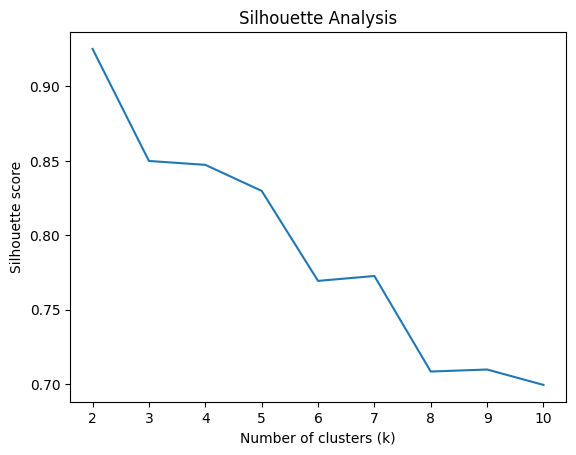

In [26]:
import matplotlib.pyplot as plt

plt.plot(k_range, silhouette_scores)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis")
plt.show()

In [27]:
print(f"Using the optimal clustering value of {best_k}.")
kmeans = KMeans(n_clusters=best_k, random_state=0, n_init = 10)
clusters = kmeans.fit_predict(X)
kmeans.cluster_centers_.shape

Using the optimal clustering value of 2.


(2, 8)

In [28]:
new_dataset['cluster'] = clusters
new_dataset.head()

,merchant,trans_amount_min,trans_amount_max,trans_amount_avg,trans_amount_volume,trans_frequency,trans_recency,avg_time_btwn_trans,avg_trans_growth_rate,cluster
0,00057d4302,1156,1279,"1,217.50",2435,2,581,1.43,0.11,0
1,000ed1585f,21932,35784,"28,050.25",112201,4,175,"3,424.03",-0.08,0
2,000f8c3297,3455,15047,"6,635.56",106169,16,59,508.47,0.23,0
3,0020aefbd9,3589,3589,"3,589.00",3589,1,216,0.00,0.00,0
4,0026f256ac,34880,34880,"34,880.00",34880,1,473,0.00,0.00,0


In [29]:
print(new_dataset['cluster'].value_counts())

cluster
0    7768
1     134
Name: count, dtype: int64


In [30]:
cluster1 = new_dataset.loc[new_dataset['cluster'] == 0]
cluster1.describe()

,trans_amount_min,trans_amount_max,trans_amount_avg,trans_amount_volume,trans_frequency,trans_recency,avg_time_btwn_trans,avg_trans_growth_rate,cluster
count,"7,768.00","7,768.00","7,768.00","7,768.00","7,768.00","7,768.00","7,768.00","7,768.00","7,768.00"
mean,"18,319.48","46,241.49","27,169.18","137,053.12",10.11,172.32,756.38,0.93,0.00
std,"60,734.98","100,336.84","67,279.26","264,184.56",33.59,180.81,"1,470.13",8.92,0.00
min,201.00,209.00,209.00,209.00,1.00,1.00,0.00,-1.00,0.00
25%,"2,085.00","6,468.50","4,793.88","10,021.00",1.00,26.00,0.00,0.00,0.00
50%,"4,249.00","15,009.50","8,868.00","33,401.00",3.00,100.00,172.45,0.01,0.00
75%,"10,523.00","38,483.75","20,448.88","128,989.25",7.00,267.00,863.75,0.53,0.00
max,"1,494,034.00","1,494,034.00","1,494,034.00","1,914,542.00","1,673.00",727.00,"15,327.18",606.65,0.00


In [31]:
cluster2 = new_dataset.loc[new_dataset['cluster'] == 1]
cluster2.describe()

,trans_amount_min,trans_amount_max,trans_amount_avg,trans_amount_volume,trans_frequency,trans_recency,avg_time_btwn_trans,avg_trans_growth_rate,cluster
count,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00
mean,"140,468.97","598,671.31","237,338.88","3,634,077.60",160.06,54.31,350.37,5.48,1.00
std,"930,220.96","1,094,164.37","941,312.50","2,280,627.47",201.19,92.14,751.11,34.91,0.00
min,211.00,"16,990.00","3,471.91","1,795,984.00",1.00,1.00,0.00,-0.54,1.00
25%,769.75,"88,539.25","15,094.21","2,200,820.50",26.00,3.00,37.37,0.32,1.00
50%,"2,775.50","245,614.50","42,665.21","2,919,060.50",65.00,8.50,123.10,0.90,1.00
75%,"9,311.50","750,150.00","139,609.64","4,186,202.00",239.25,64.50,344.74,1.86,1.00
max,"10,385,508.00","10,385,508.00","10,385,508.00","15,499,827.00",817.00,486.00,"6,943.55",402.13,1.00


Looking at the summary data by cluster, there are some clear differences. Cluster one is smaller sales and more often. Cluster two is larger sales and less often. I will go back to the detail data and see what that looks like.

In [40]:
HW7F1C = pd.merge(HW7F1,new_dataset[['merchant','cluster']], left_on='merchant',right_on='merchant', how='left')
HW7F1C

,merchant,time,amount_usd_in_cents,cluster
0,81512d8413,2033-01-01 16:16:19,3597,0
1,32cd721943,2033-01-01 16:57:21,6776,0
2,a8ff2d667e,2033-01-01 18:39:19,6780,1
3,81512d8413,2033-01-01 22:45:05,4378,0
4,878047f4b9,2033-01-01 23:49:57,4372,0
...,...,...,...,...
99995,f7ba9d03d4,2034-12-31 06:54:38,9221,0
99996,de9e4801de,2034-12-31 06:55:16,2274,0
99997,164ba405db,2034-12-31 07:14:04,80272,0
99998,7851aedb5b,2034-12-31 07:27:21,5205,0


We now have the original 10,000 rows. Let's make sure that they all have a cluster assignment.

In [41]:
print(HW7F1C['cluster'].value_counts())

cluster
0    78552
1    21448
Name: count, dtype: int64


ALl present and accounted for. Let's describe each cluster.

In [42]:
HW7F1C0 = HW7F1C.loc[HW7F1C['cluster'] == 0]
HW7F1C0.describe()

,time,amount_usd_in_cents,cluster
count,78552,"78,552.00","78,552.00"
mean,2034-05-09 15:26:26.014066944,"13,553.17",0.00
min,2033-01-01 16:16:19,201.00,0.00
25%,2034-01-13 22:50:14.500000,"2,943.00",0.00
50%,2034-06-15 21:55:57,"5,615.00",0.00
75%,2034-10-03 13:41:01.249999872,"11,269.00",0.00
max,2034-12-31 07:55:58,"1,494,034.00",0.00
std,NaN,"38,167.51",0.00


In [43]:
HW7F1C1 = HW7F1C.loc[HW7F1C['cluster'] == 1]
HW7F1C1.describe()

,time,amount_usd_in_cents,cluster
count,21448,"21,448.00","21,448.00"
mean,2034-04-11 09:55:38.616887296,"22,704.51",1.00
min,2033-01-01 18:39:19,211.00,1.00
25%,2033-12-10 03:20:04.249999872,"4,736.00",1.00
50%,2034-05-06 05:42:34.500000,"8,550.00",1.00
75%,2034-09-20 04:46:24.249999872,"18,301.25",1.00
max,2034-12-31 06:47:09,"10,385,508.00",1.00
std,NaN,"106,648.07",0.00


No additional insight. I am not clear how this data could tell me what the merchants are. Maybe if one was house price range and the other was car price range, I could distinguish them. But, the prices do not seem to indicate anything.

## Task 3: Churn Prediction
- Background: Customer retention is a key growth pillar. Churn or customer
attrition is defined as customers who have had no transactions within a 30-day
period, indicating a ”rolling” Monthly Recurring Revenue (MRR) of $0.
- Goal: Develop a churn prediction model.
    - Generate binary labels for churn and no churn based on the 30-day inactivity criterion.
    - Use the generated features and any algorithm(s) of your choice for the model.
    - Present metrics from your experiments and feature importance.

In [51]:
pd.set_option('display.max_rows', None)
HW7F1SM = HW7F1.sort_values(by=['merchant','time'])
HW7F1SM['amount_usd_in_dol'] = HW7F1SM['amount_usd_in_cents'] / 100
HW7F1SM['year'] = pd.DatetimeIndex(HW7F1SM['time']).year
HW7F1SM['month'] = pd.DatetimeIndex(HW7F1SM['time']).month
HW7F1SM.head(100)

,merchant,time,amount_usd_in_cents,amount_usd_in_dol,year,month
61145,00057d4302,2033-05-30 02:54:34,1156,11.56,2033,5
31634,00057d4302,2033-05-30 04:20:31,1279,12.79,2033,5
61838,000ed1585f,2033-05-08 15:51:43,32004,320.04,2033,5
91379,000ed1585f,2033-05-19 13:15:51,35784,357.84,2033,5
33565,000ed1585f,2033-05-27 01:28:43,21932,219.32,2033,5
98537,000ed1585f,2034-07-10 15:57:48,22481,224.81,2034,7
35788,000f8c3297,2033-12-20 17:57:20,7374,73.74,2033,12
57871,000f8c3297,2034-01-26 15:10:54,14489,144.89,2034,1
23198,000f8c3297,2034-02-15 21:54:30,15047,150.47,2034,2
58459,000f8c3297,2034-03-30 13:27:16,4623,46.23,2034,3


In [49]:
print(f"The earliest time is {HW7F1['time'].min()} and the latest time is {HW7F1['time'].max()}.")

The earliest time is 2033-01-01 16:16:19 and the latest time is 2034-12-31 07:55:58.


I am at a loss for how to determine customers. Merchants sell things to customers. I see no way to tell which customer the merchant is selling to.

## Deliverables
- For Merchant Segmentation:
    - Cluster assignments for each merchant.
    - Exploratory data analysis report for each cluster.
- For Churn Prediction:
    - A developed churn prediction model.
    - Experiment metrics and analysis of feature importance.

# Question 2: Unsupervised Learning on Property Dataset with PCA and Clustering Techniques
Given the comprehensive dataset provided from Zillow, which encompasses various features ranging from architectural details to taxation information, students are tasked to
apply unsupervised learning methods to uncover underlying patterns in the data. The assignment will involve two main techniques: Principal Component Analysis (PCA) and Clustering.

## Objective
- Use PCA to reduce the dimensionality of the dataset, thus simplifying the data
without significant loss of information.
- Apply clustering techniques to identify distinct groups within the Zillow dataset
that share similar characteristics.


## Tasks
### Data Preprocessing:
- Dataset: homework7 file2.csv
- Normalize the features in the dataset to ensure that the PCA and clustering algorithms function correctly.
- Handle missing values and categorical variables appropriately.


In [53]:
HW7F2 = pd.read_csv('./homework7_file2.csv')
HW7F2.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,12833975,NaN,NaN,NaN,3.00,4.00,NaN,6.00,3.00,NaN,NaN,"1,812.00","1,812.00",NaN,NaN,NaN,NaN,"6,037.00",NaN,3.00,NaN,NaN,NaN,2.00,"33,999,334.00","-117,955,651.00","5,419.00",NaN,NaN,NaN,NaN,NaN,0100,261.00,LCR106,"60,374,086.31","45,602.00","3,101.00",NaN,"96,489.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,955.00",NaN,NaN,"155,403.00","304,592.00","2,016.00","149,189.00","3,708.29",NaN,NaN,"60,374,100,000,000.00"
1,11070096,1.00,NaN,NaN,4.00,4.00,NaN,7.00,4.00,NaN,NaN,"3,134.00","3,134.00",NaN,NaN,NaN,NaN,"6,037.00",NaN,4.00,NaN,NaN,NaN,2.00,"34,283,974.00","-118,583,756.00",NaN,NaN,NaN,NaN,NaN,NaN,010D,269.00,LARE,"60,371,082.02","12,447.00","3,101.00","275,078.00","96,356.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"2,012.00",NaN,NaN,"493,070.00","821,783.00","2,016.00","328,713.00","10,087.59",NaN,NaN,"60,371,100,000,000.00"
2,12752672,1.00,NaN,NaN,2.00,3.00,NaN,6.00,2.00,NaN,NaN,"1,817.00","1,817.00",NaN,NaN,NaN,NaN,"6,037.00",NaN,2.00,NaN,NaN,NaN,2.00,"33,899,765.00","-117,989,887.00","5,953.00",NaN,NaN,NaN,NaN,NaN,0100,261.00,LMR1*,"60,375,038.01","5,465.00","3,101.00",NaN,"96,190.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"1,957.00",NaN,NaN,"126,695.00","247,962.00","2,016.00","121,267.00","3,377.86",NaN,NaN,"60,375,000,000,000.00"
3,11338563,NaN,NaN,NaN,3.00,4.00,NaN,7.00,3.00,NaN,NaN,"2,280.00","2,280.00",NaN,NaN,NaN,NaN,"6,037.00",NaN,3.00,NaN,NaN,NaN,NaN,"34,674,776.00","-118,418,589.00","856,438.00",NaN,NaN,NaN,NaN,NaN,0700,263.00,LCRA10000-,"60,379,201.02","25,468.00","3,101.00",NaN,"97,316.00",0.00,NaN,NaN,NaN,1.00,NaN,NaN,"2,006.00",NaN,NaN,"130,500.00","308,900.00","2,016.00","178,400.00","3,578.92",NaN,NaN,"60,379,200,000,000.00"
4,17098704,NaN,NaN,NaN,0.00,3.00,NaN,NaN,NaN,NaN,"1,200.00","1,200.00","1,200.00",NaN,NaN,"1,200.00",NaN,"6,111.00",NaN,NaN,2.00,400.00,NaN,NaN,"34,364,318.00","-119,055,992.00","6,750.00",NaN,NaN,NaN,NaN,NaN,1110,261.00,NaN,"61,110,004.00","26,965.00","2,061.00",NaN,"97,113.00",5.00,NaN,NaN,NaN,NaN,NaN,NaN,"1,987.00",1.00,NaN,"142,271.00","223,101.00","2,016.00","80,830.00","2,564.86",NaN,NaN,"61,110,000,000,000.00"


In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Define categorical and numeric feature lists (replace with actual column names)
#categorical_features = [col for col in HW7F2.columns if HW7F2[col].dtype == 'object']
#numeric_features = [col for col in HW7F2.columns if col not in categorical_features]
categorical_features = ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']
numeric_features = ['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 'censustractandblock']
id_features = ['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'storytypeid', 'typeconstructiontypeid']
print(categorical_features)
print(numeric_features)

# Create transformers for categorical and numeric features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numeric_transformer = StandardScaler()

# Combine transformers into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

# Create the pipeline with preprocessing and imputation steps
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='mean'))  # Impute remaining missing values after encoding
])

# Fit the pipeline to your data (optional, requires data)
pipeline.fit(HW7F2)

# Transformed data (after fitting)
transformed_data = pipeline.transform(HW7F2)


['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']
['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 'censustractandblock']


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['bool', 'str']


### Principal Component Analysis (PCA):
- Implement PCA on the preprocessed dataset.
- Determine the number of principal components to retain by examining the explained variance ratio.
### Clustering:
- Choose a suitable clustering algorithm, such as K-means or hierarchical clustering.
- Utilize the silhouette score and/or the elbow method to find the optimal number of clusters.
- Cluster the data based on the principal components derived from PCA.
### Cluster Analysis and Interpretation:
- Perform an exploratory data analysis (EDA) on each cluster to understand the properties and characteristics of the different groups.
- Identify and describe the types of properties in each cluster, considering features
such as ’yearbuilt’, ’roomcnt’, ’bathroomcnt’, ’zipcode’ and others relevant to real
estate valuation.
### Reporting:
- Present a detailed report of the PCA and clustering process.
- Provide an insightful interpretation of each cluster, supported by statistical summaries and visualizations.
- Discuss the potential implications of your findings for stakeholders in the real estate market.
## Deliverables
- A Jupyter notebook containing the PCA and clustering code with detailed annotations explaining each step.
- A written report summarizing the methodology, findings, and interpretations of the clusters.
- Visual aids such as scatter plots, bar charts, and heatmaps to illustrate the characteristics of each cluster.
## Additional Notes
- The dataset is expected to contain a mix of numerical and categorical data; proper encoding methods should be applied.
- Clusters should be profiled based on key features that could be useful for property market segmentation.
- This assignment will test your ability to apply unsupervised machine learning techniques to real-world datasets and derive actionable insights that can inform business
strategy.